<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2023-11-01 10:19:09--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2023-11-01 10:19:10--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   2.57K  --.-KB/s    in 0.004s  

2023-11-01 10:19:11 (610 KB/s) - ‘utils.py.1’ saved [

In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [13]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        #self.features = nn.Sequential(
        #    nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
        #    nn.Tanh(),
        #    nn.MaxPool2d((2, 2), stride=2, padding=0),
        #    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
        #    nn.Tanh(),
        #    nn.MaxPool2d((2, 2), stride=2, padding=0),
        #)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        #self.classifier = nn.Sequential(
        #    nn.Linear(400, 120),
        #    nn.Tanh(),
        #    nn.Linear(120, 84),
        #    nn.Tanh(),
        #    nn.Linear(84, 10)
        #    # Reminder: The softmax is included in the loss, do not put it here
        #)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    #train_dataset = datasets.MNIST(PATH, train=True, download=True,
    #    transform=transforms.Compose([
    #        transforms.ToTensor()
    #    ]))
    #val_dataset = datasets.MNIST(PATH, train=False, download=True,
    #    transform=transforms.Compose([
    #        transforms.ToTensor()
    #    ]))

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
            transforms.RandomCrop(size=28),
            transforms.RandomHorizontalFlip(p=1./2.)
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
            transforms.RandomCrop(size=28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.206s (0.206s)	Loss 2.3059 (2.3059)	Prec@1  10.9 ( 10.9)	Prec@5  47.7 ( 47.7)


<Figure size 640x480 with 0 Axes>

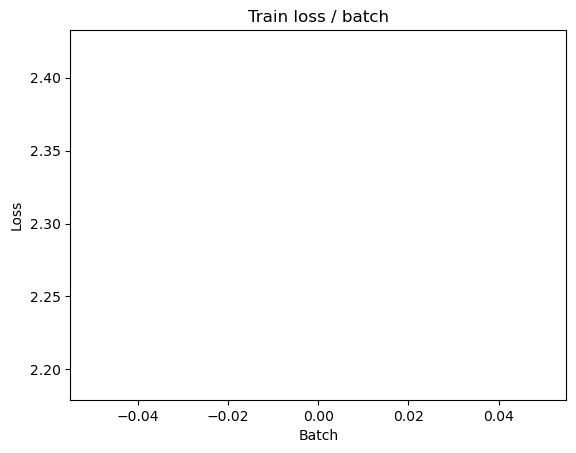

[TRAIN Batch 200/391]	Time 0.084s (0.083s)	Loss 2.0841 (2.2475)	Prec@1  22.7 ( 15.5)	Prec@5  69.5 ( 61.4)


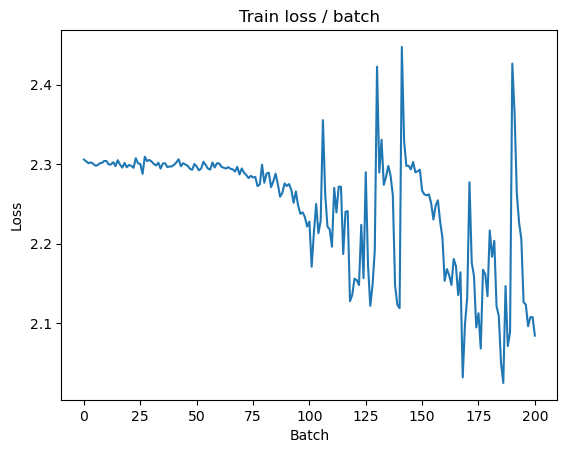


===============> Total time 32s	Avg loss 2.1722	Avg Prec@1 19.72 %	Avg Prec@5 67.35 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 2.0665 (2.0665)	Prec@1  22.7 ( 22.7)	Prec@5  82.0 ( 82.0)

===============> Total time 3s	Avg loss 2.0282	Avg Prec@1 26.24 %	Avg Prec@5 78.60 %



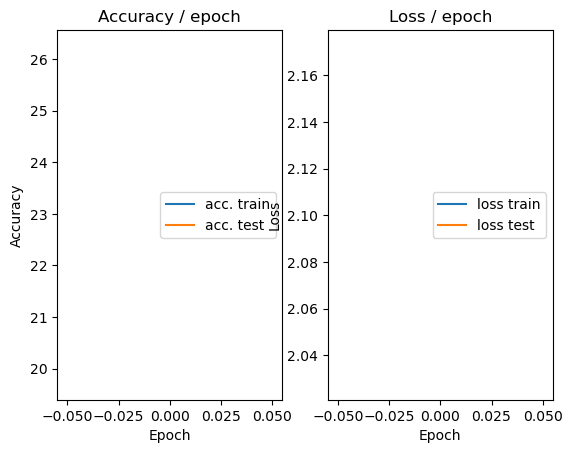

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.231s (0.231s)	Loss 2.0755 (2.0755)	Prec@1  25.0 ( 25.0)	Prec@5  75.8 ( 75.8)


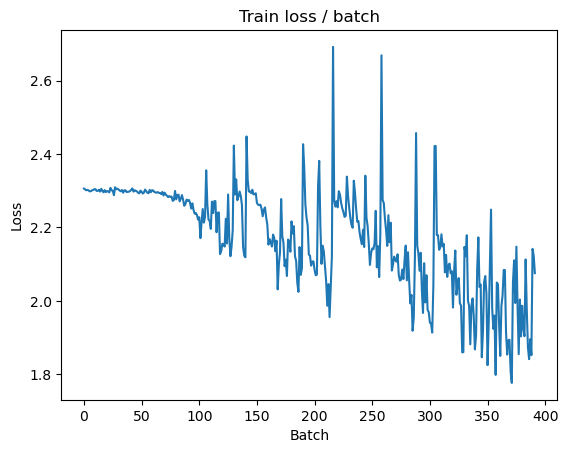

[TRAIN Batch 200/391]	Time 0.074s (0.079s)	Loss 1.6773 (1.8383)	Prec@1  39.8 ( 34.3)	Prec@5  85.9 ( 84.5)


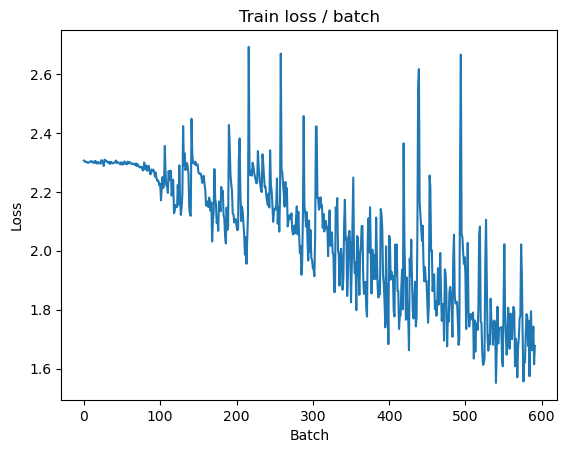


===============> Total time 30s	Avg loss 1.7363	Avg Prec@1 37.61 %	Avg Prec@5 86.71 %

[EVAL Batch 000/079]	Time 0.120s (0.120s)	Loss 1.4508 (1.4508)	Prec@1  48.4 ( 48.4)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.5044	Avg Prec@1 45.22 %	Avg Prec@5 91.90 %



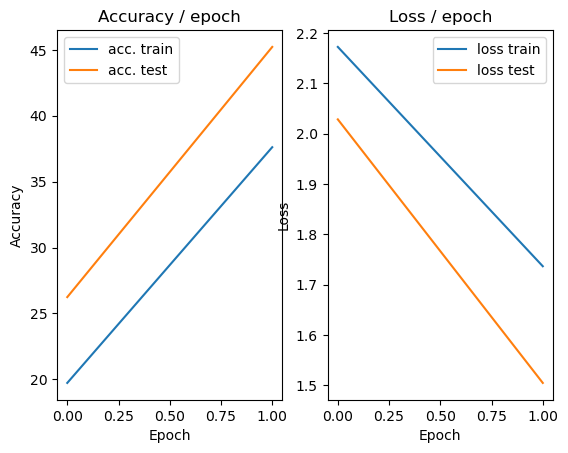

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.239s (0.239s)	Loss 1.4467 (1.4467)	Prec@1  50.8 ( 50.8)	Prec@5  93.8 ( 93.8)


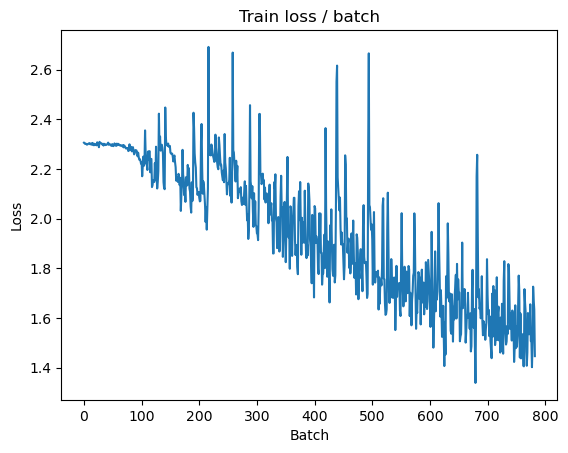

[TRAIN Batch 200/391]	Time 0.074s (0.078s)	Loss 1.5625 (1.4868)	Prec@1  43.8 ( 46.2)	Prec@5  92.2 ( 91.8)


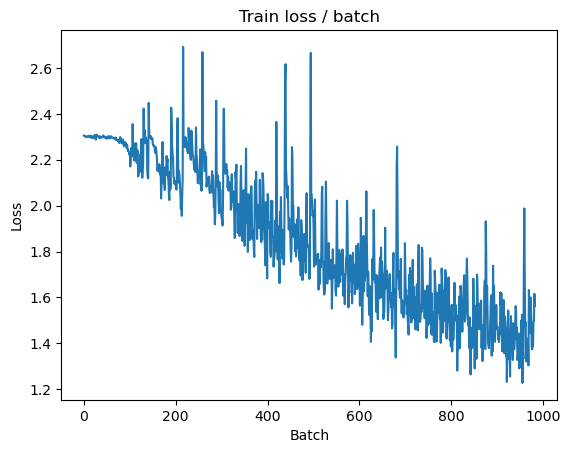


===============> Total time 30s	Avg loss 1.4430	Avg Prec@1 48.02 %	Avg Prec@5 92.36 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.2442 (1.2442)	Prec@1  57.0 ( 57.0)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.3396	Avg Prec@1 51.35 %	Avg Prec@5 93.59 %



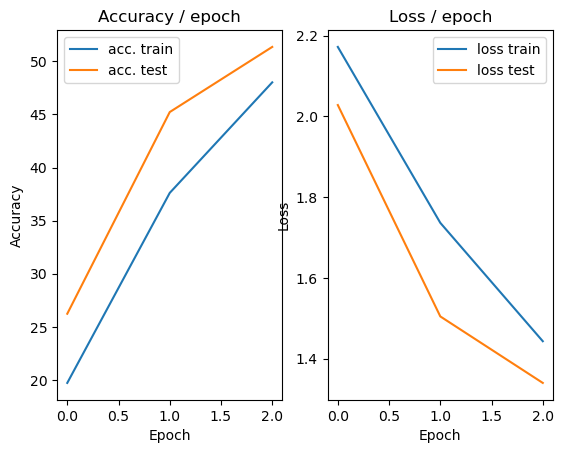

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 1.2756 (1.2756)	Prec@1  52.3 ( 52.3)	Prec@5  95.3 ( 95.3)


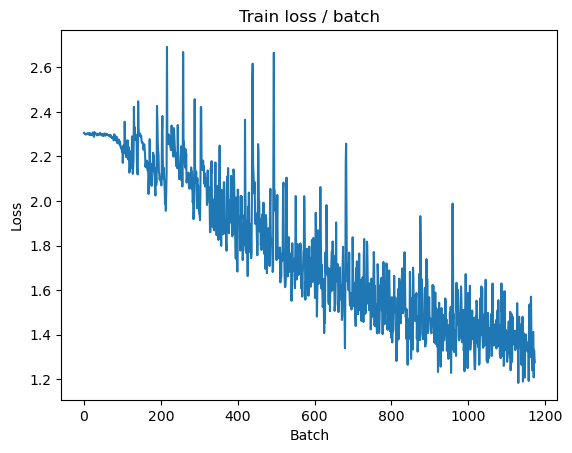

[TRAIN Batch 200/391]	Time 0.075s (0.078s)	Loss 1.3326 (1.3098)	Prec@1  50.0 ( 53.0)	Prec@5  94.5 ( 94.1)


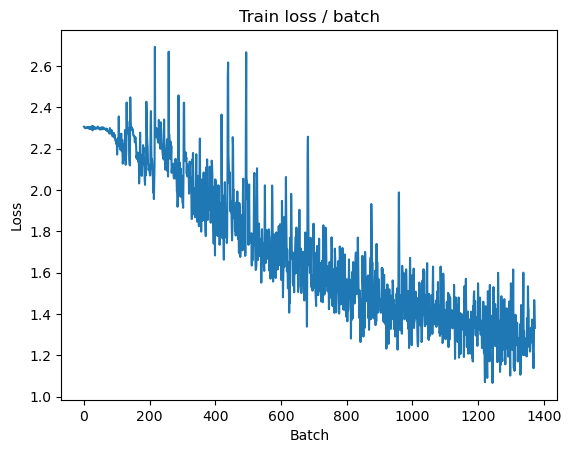


===============> Total time 30s	Avg loss 1.2748	Avg Prec@1 54.32 %	Avg Prec@5 94.50 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.1568 (1.1568)	Prec@1  60.9 ( 60.9)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.2027	Avg Prec@1 56.57 %	Avg Prec@5 95.42 %



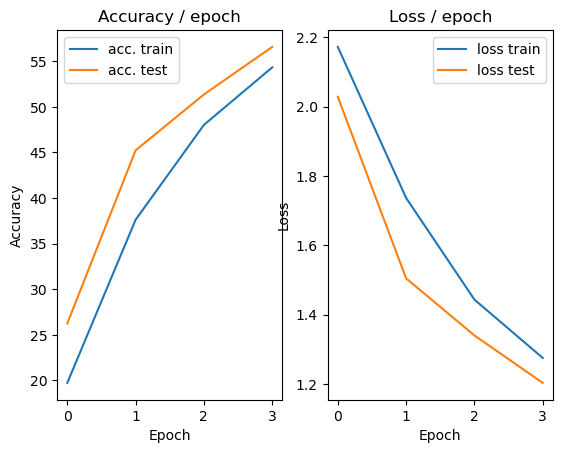

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 1.1393 (1.1393)	Prec@1  60.2 ( 60.2)	Prec@5  96.9 ( 96.9)


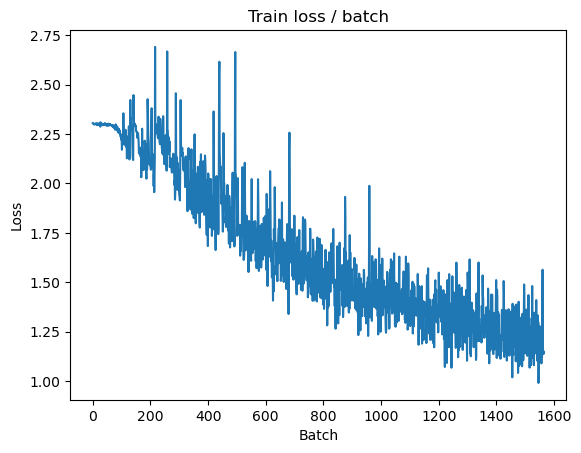

[TRAIN Batch 200/391]	Time 0.075s (0.078s)	Loss 1.1894 (1.1454)	Prec@1  53.1 ( 58.8)	Prec@5  95.3 ( 95.8)


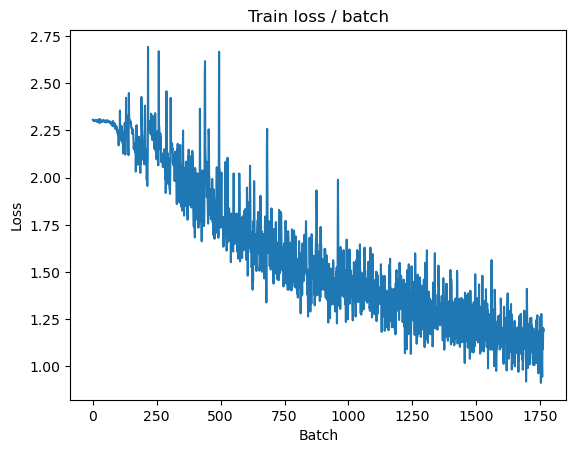


===============> Total time 30s	Avg loss 1.1311	Avg Prec@1 59.50 %	Avg Prec@5 95.91 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.1012 (1.1012)	Prec@1  63.3 ( 63.3)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.2313	Avg Prec@1 56.58 %	Avg Prec@5 94.34 %



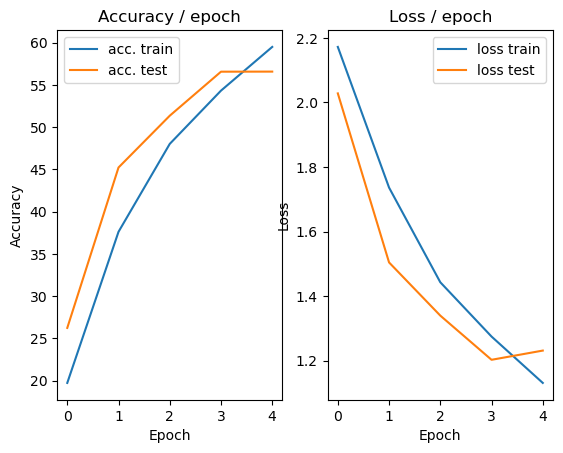

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.227s (0.227s)	Loss 1.2192 (1.2192)	Prec@1  55.5 ( 55.5)	Prec@5  94.5 ( 94.5)


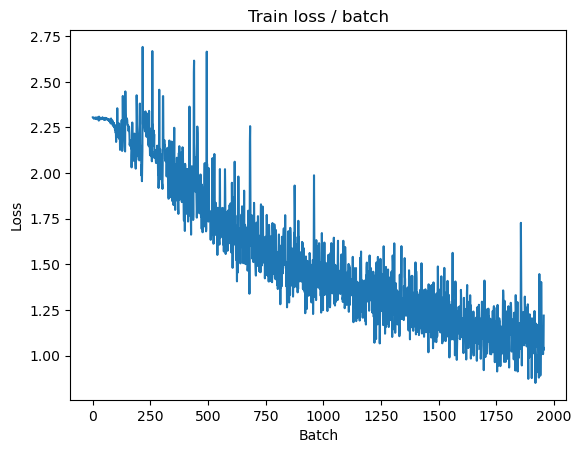

[TRAIN Batch 200/391]	Time 0.112s (0.078s)	Loss 1.1396 (1.0191)	Prec@1  53.9 ( 64.1)	Prec@5  94.5 ( 96.8)


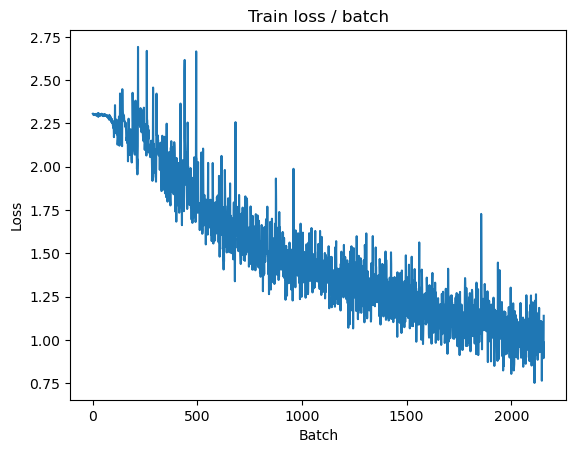


===============> Total time 30s	Avg loss 1.0084	Avg Prec@1 64.29 %	Avg Prec@5 96.77 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 1.0448 (1.0448)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.1191	Avg Prec@1 60.25 %	Avg Prec@5 96.02 %



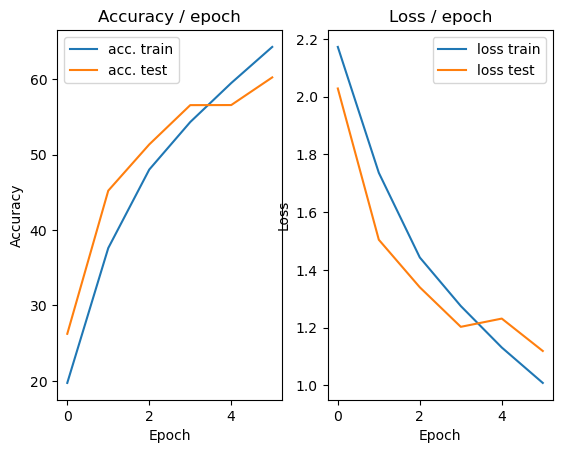

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 1.0442 (1.0442)	Prec@1  64.8 ( 64.8)	Prec@5  99.2 ( 99.2)


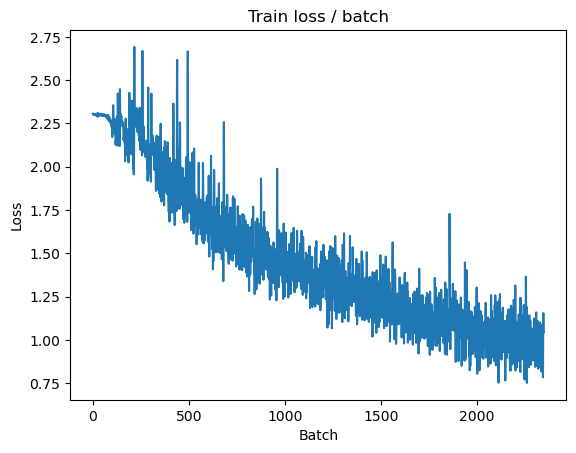

[TRAIN Batch 200/391]	Time 0.074s (0.077s)	Loss 0.9902 (0.9240)	Prec@1  66.4 ( 67.5)	Prec@5  96.1 ( 97.4)


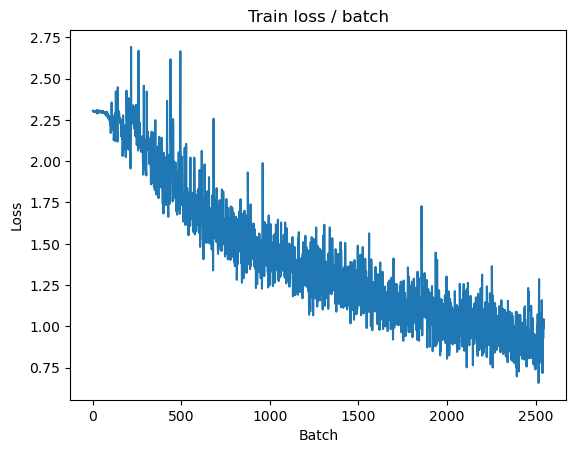


===============> Total time 30s	Avg loss 0.9030	Avg Prec@1 68.21 %	Avg Prec@5 97.47 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 0.9179 (0.9179)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0319	Avg Prec@1 64.17 %	Avg Prec@5 96.64 %



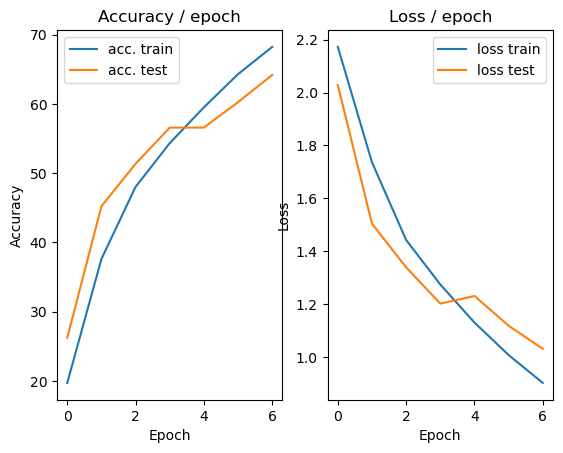

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.260s (0.260s)	Loss 0.9202 (0.9202)	Prec@1  64.8 ( 64.8)	Prec@5  98.4 ( 98.4)


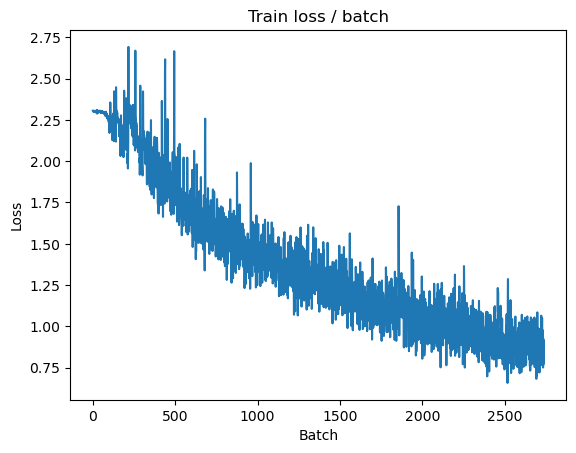

[TRAIN Batch 200/391]	Time 0.076s (0.083s)	Loss 1.1649 (0.8063)	Prec@1  61.7 ( 71.8)	Prec@5  94.5 ( 98.1)


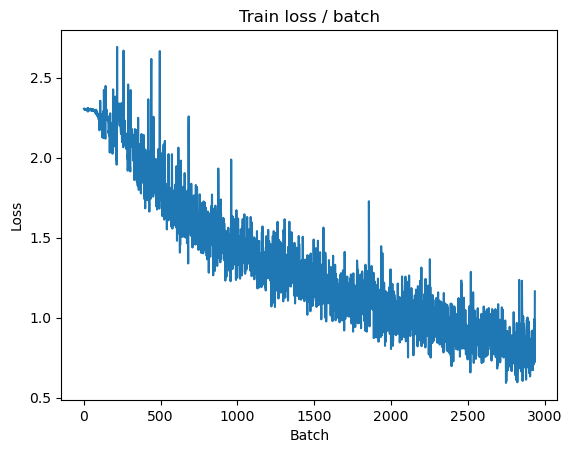


===============> Total time 31s	Avg loss 0.8040	Avg Prec@1 71.98 %	Avg Prec@5 98.12 %

[EVAL Batch 000/079]	Time 0.128s (0.128s)	Loss 0.9779 (0.9779)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 0.9280	Avg Prec@1 67.70 %	Avg Prec@5 97.14 %



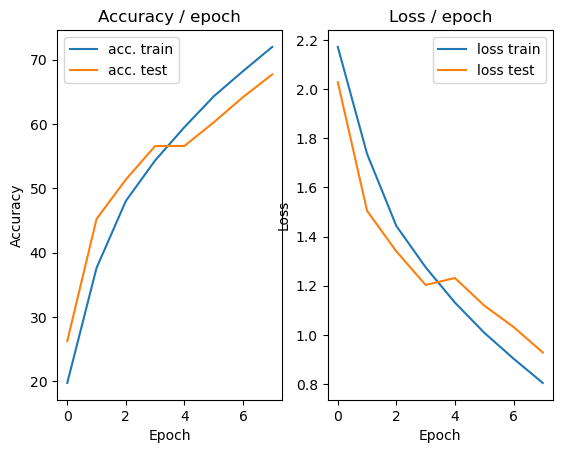

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 0.6045 (0.6045)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


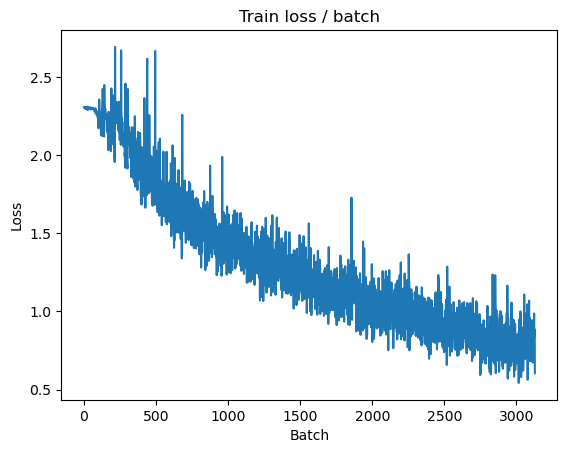

[TRAIN Batch 200/391]	Time 0.083s (0.081s)	Loss 0.6761 (0.6900)	Prec@1  71.1 ( 75.7)	Prec@5  97.7 ( 98.7)


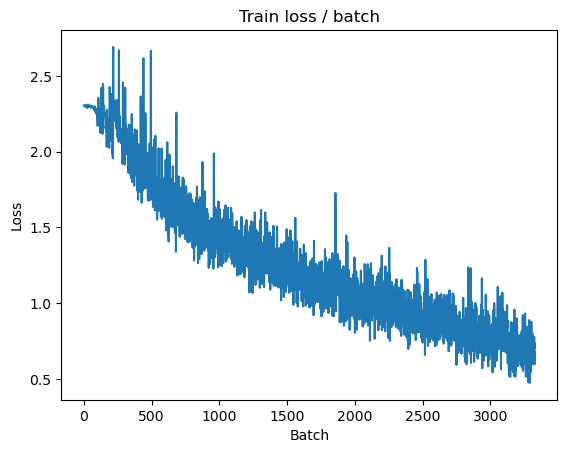


===============> Total time 31s	Avg loss 0.7020	Avg Prec@1 75.31 %	Avg Prec@5 98.64 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 0.9056 (0.9056)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 0.9701	Avg Prec@1 66.62 %	Avg Prec@5 96.71 %



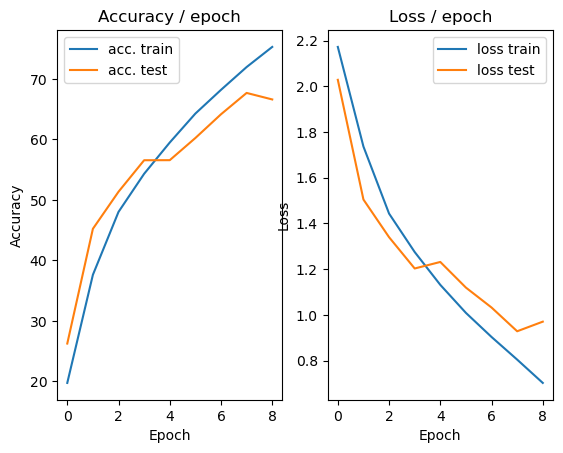

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.6046 (0.6046)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


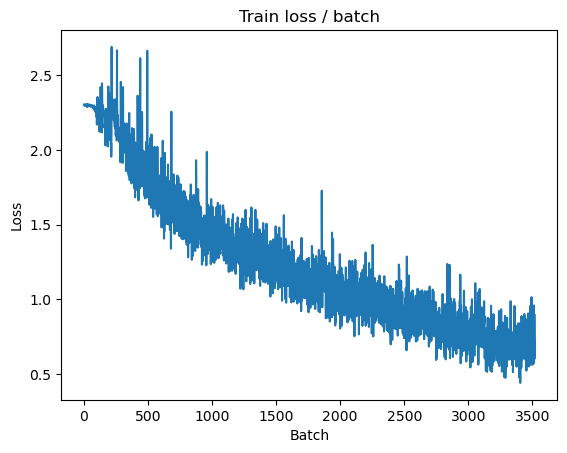

[TRAIN Batch 200/391]	Time 0.083s (0.082s)	Loss 0.5734 (0.6021)	Prec@1  78.1 ( 78.9)	Prec@5  99.2 ( 99.0)


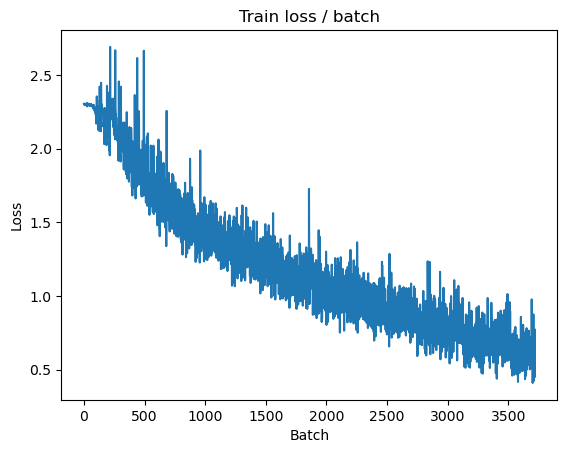


===============> Total time 32s	Avg loss 0.6122	Avg Prec@1 78.54 %	Avg Prec@5 98.95 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.9949 (0.9949)	Prec@1  67.2 ( 67.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9439	Avg Prec@1 68.55 %	Avg Prec@5 97.37 %



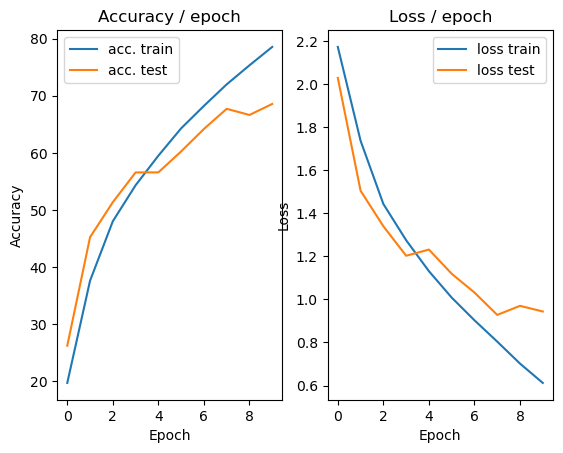

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.252s (0.252s)	Loss 0.4349 (0.4349)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


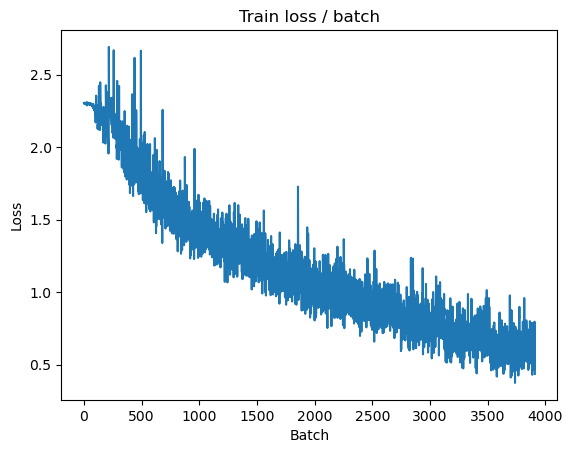

[TRAIN Batch 200/391]	Time 0.076s (0.084s)	Loss 0.4544 (0.5008)	Prec@1  88.3 ( 82.3)	Prec@5  99.2 ( 99.4)


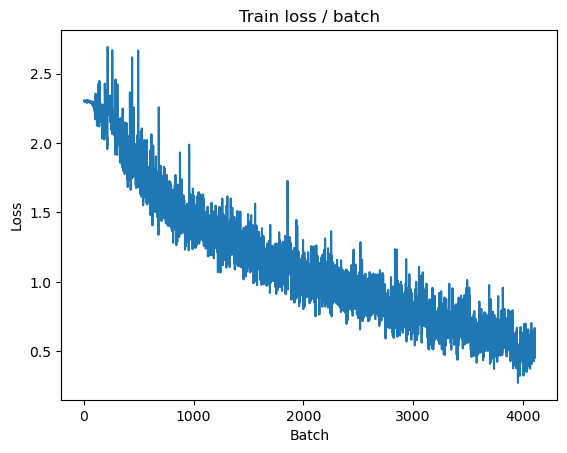


===============> Total time 32s	Avg loss 0.5184	Avg Prec@1 81.69 %	Avg Prec@5 99.37 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 1.0389 (1.0389)	Prec@1  67.2 ( 67.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 1.0386	Avg Prec@1 67.65 %	Avg Prec@5 97.17 %



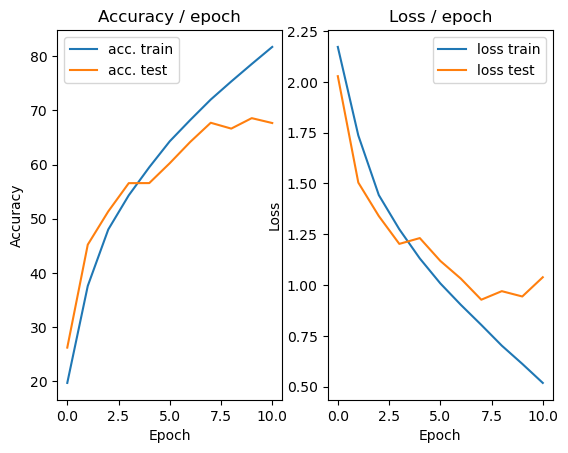

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.233s (0.233s)	Loss 0.5556 (0.5556)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)


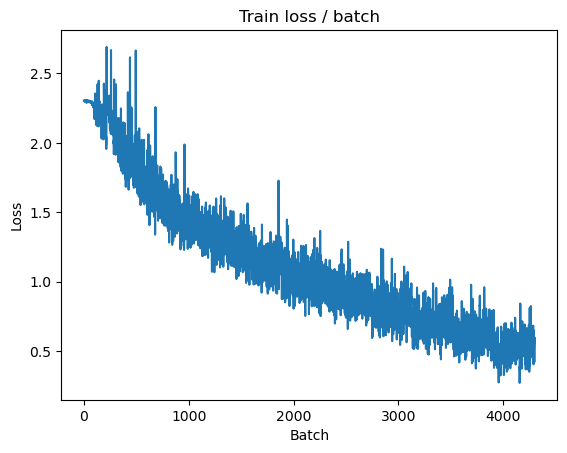

[TRAIN Batch 200/391]	Time 0.075s (0.084s)	Loss 0.5246 (0.4092)	Prec@1  82.0 ( 85.8)	Prec@5  98.4 ( 99.7)


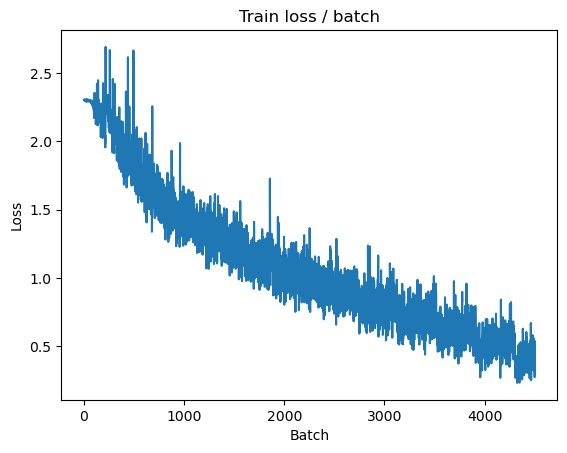


===============> Total time 32s	Avg loss 0.4253	Avg Prec@1 85.05 %	Avg Prec@5 99.63 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 0.9804 (0.9804)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.9967	Avg Prec@1 68.32 %	Avg Prec@5 96.93 %



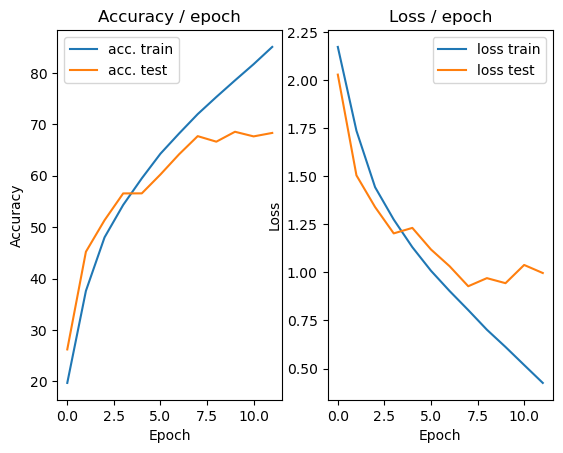

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.2910 (0.2910)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


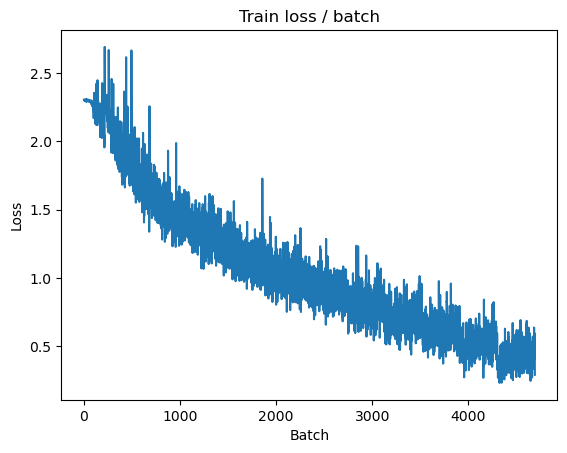

[TRAIN Batch 200/391]	Time 0.076s (0.080s)	Loss 0.3107 (0.3096)	Prec@1  88.3 ( 89.4)	Prec@5 100.0 ( 99.8)


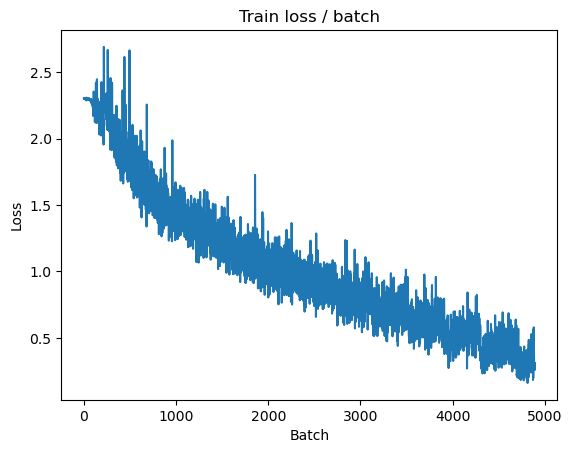


===============> Total time 31s	Avg loss 0.3313	Avg Prec@1 88.51 %	Avg Prec@5 99.80 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 1.2745 (1.2745)	Prec@1  68.0 ( 68.0)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 1.1670	Avg Prec@1 68.40 %	Avg Prec@5 96.95 %



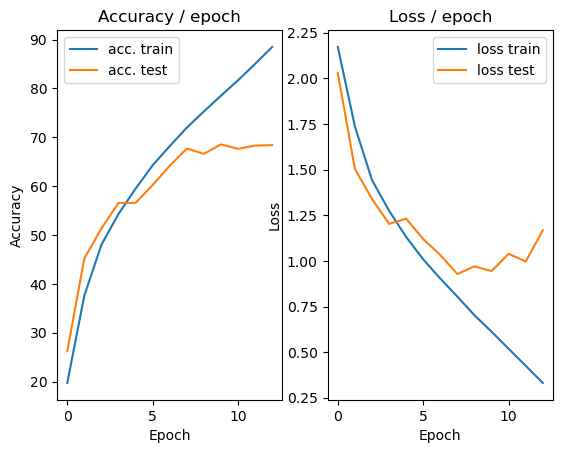

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.206s (0.206s)	Loss 0.2284 (0.2284)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


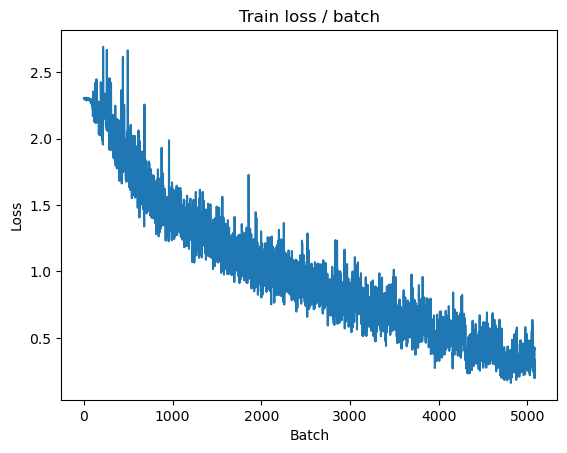

[TRAIN Batch 200/391]	Time 0.078s (0.083s)	Loss 0.1865 (0.2312)	Prec@1  94.5 ( 92.2)	Prec@5 100.0 ( 99.9)


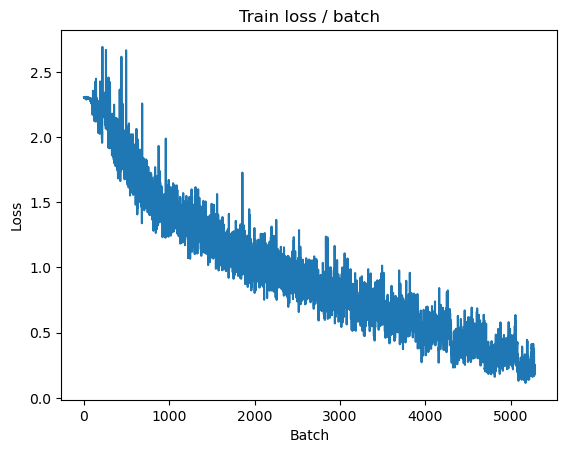


===============> Total time 30s	Avg loss 0.2532	Avg Prec@1 91.30 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.136s (0.136s)	Loss 1.1598 (1.1598)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.1368	Avg Prec@1 68.08 %	Avg Prec@5 97.26 %



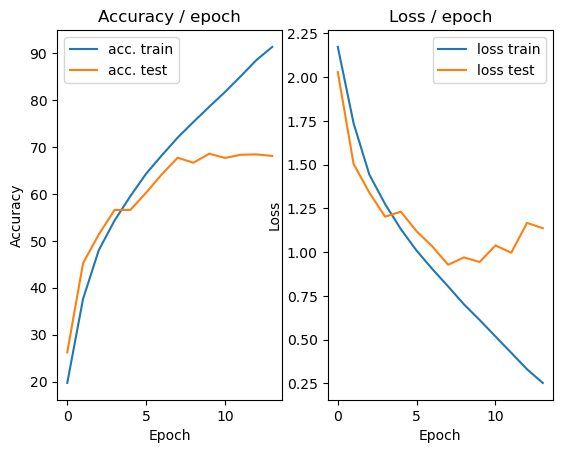

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.219s (0.219s)	Loss 0.1420 (0.1420)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


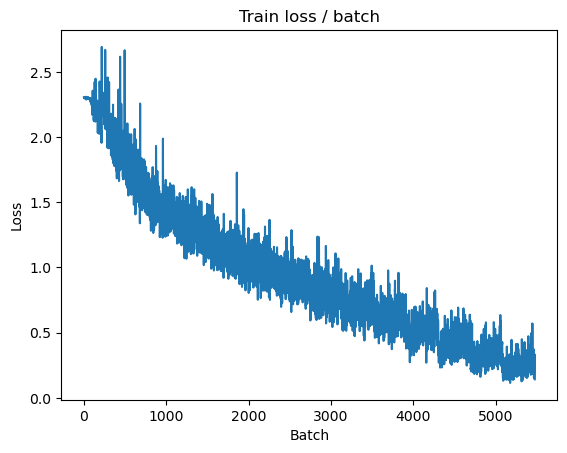

[TRAIN Batch 200/391]	Time 0.076s (0.077s)	Loss 0.1943 (0.1627)	Prec@1  93.8 ( 94.7)	Prec@5 100.0 (100.0)


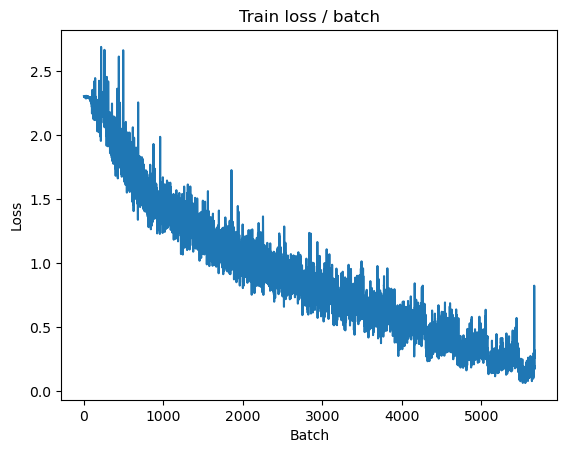


===============> Total time 29s	Avg loss 0.1827	Avg Prec@1 93.83 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 1.3220 (1.3220)	Prec@1  68.8 ( 68.8)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.1932	Avg Prec@1 69.49 %	Avg Prec@5 97.06 %



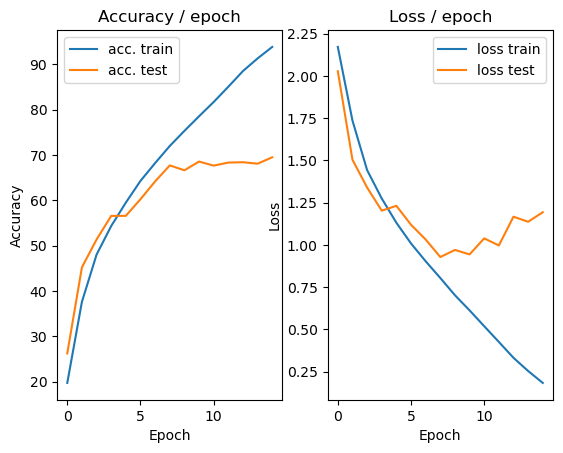

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.244s (0.244s)	Loss 0.1370 (0.1370)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


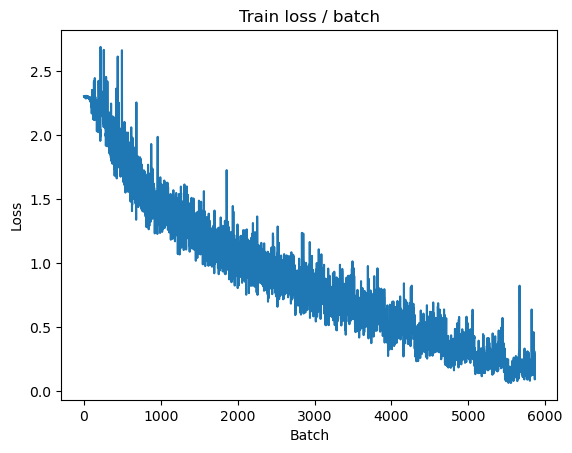

[TRAIN Batch 200/391]	Time 0.074s (0.077s)	Loss 0.1577 (0.1134)	Prec@1  93.8 ( 96.3)	Prec@5 100.0 (100.0)


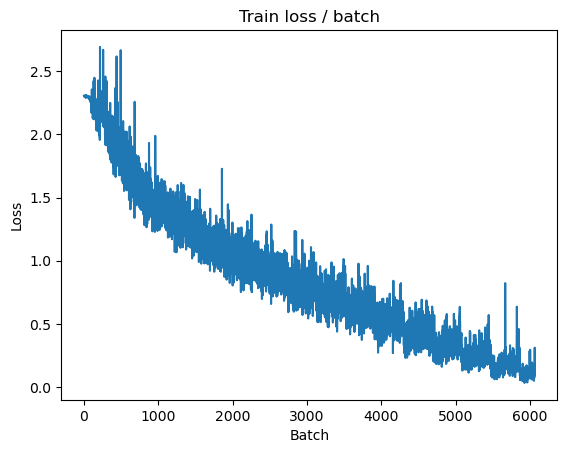


===============> Total time 30s	Avg loss 0.1326	Avg Prec@1 95.61 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 1.4951 (1.4951)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 1.2650	Avg Prec@1 71.04 %	Avg Prec@5 97.09 %



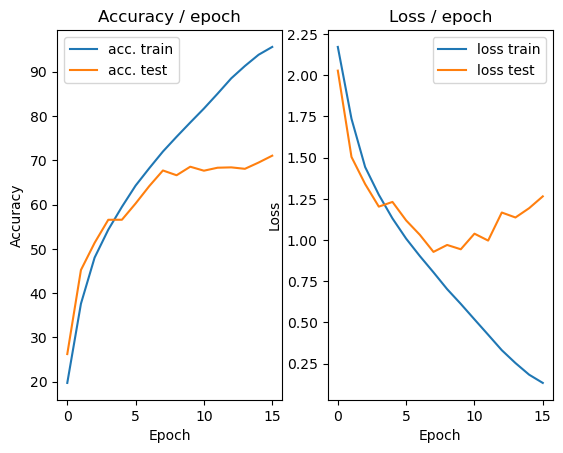

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.0566 (0.0566)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


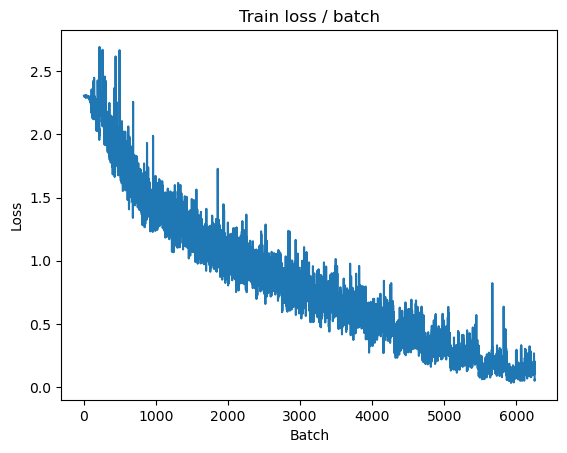

[TRAIN Batch 200/391]	Time 0.079s (0.084s)	Loss 0.0507 (0.0678)	Prec@1  98.4 ( 98.0)	Prec@5 100.0 (100.0)


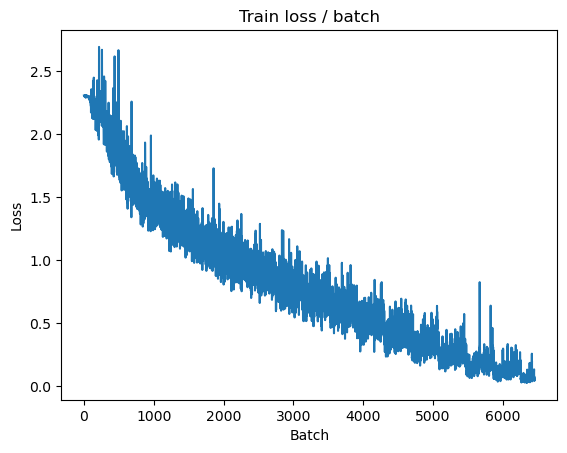


===============> Total time 32s	Avg loss 0.0941	Avg Prec@1 97.08 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 1.3869 (1.3869)	Prec@1  65.6 ( 65.6)	Prec@5  96.9 ( 96.9)

===============> Total time 3s	Avg loss 1.4148	Avg Prec@1 69.42 %	Avg Prec@5 96.85 %



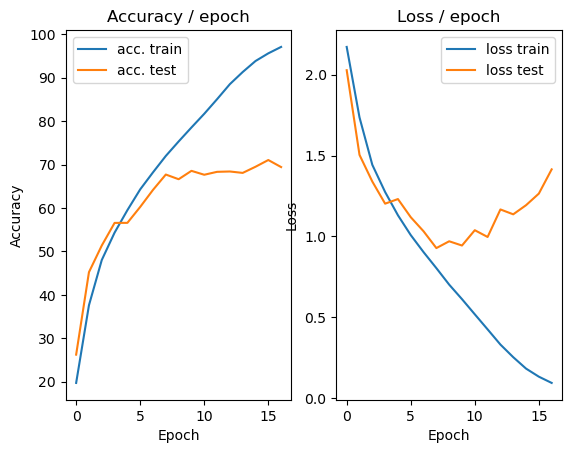

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.233s (0.233s)	Loss 0.1444 (0.1444)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


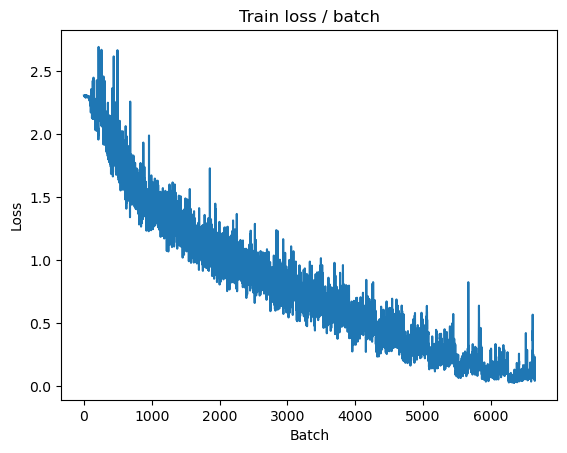

[TRAIN Batch 200/391]	Time 0.076s (0.081s)	Loss 0.0372 (0.0459)	Prec@1  98.4 ( 98.8)	Prec@5 100.0 (100.0)


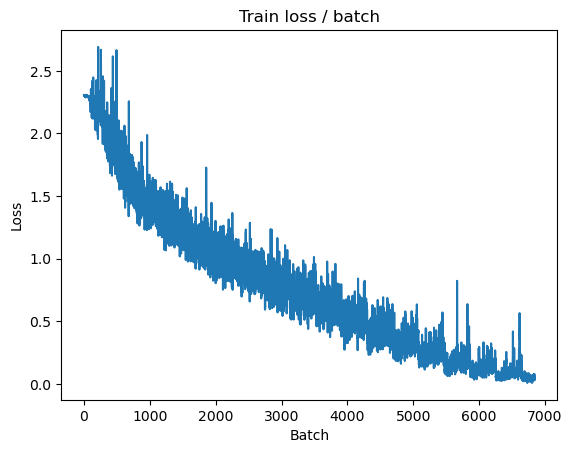


===============> Total time 31s	Avg loss 0.1210	Avg Prec@1 96.98 %	Avg Prec@5 99.78 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.3499 (1.3499)	Prec@1  59.4 ( 59.4)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.3665	Avg Prec@1 57.20 %	Avg Prec@5 93.59 %



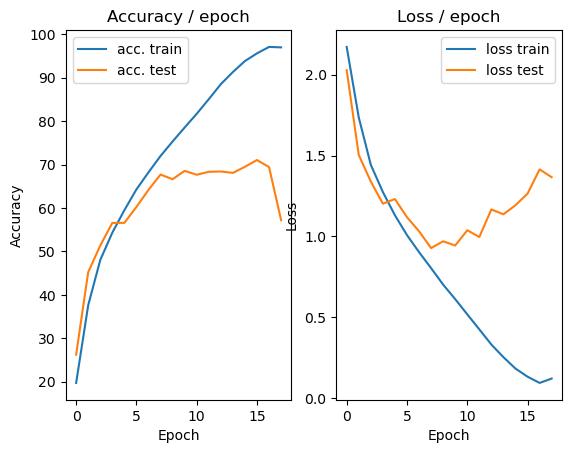

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.8415 (0.8415)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)


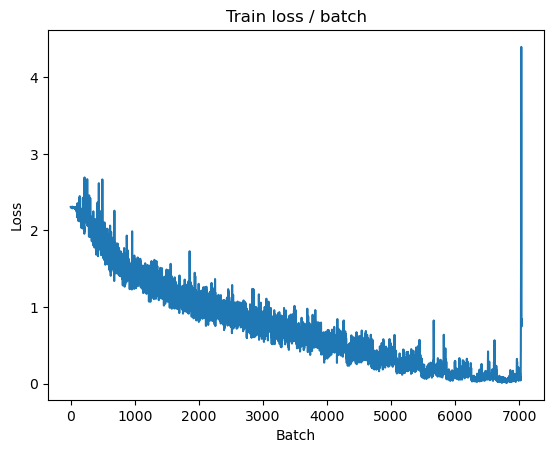

[TRAIN Batch 200/391]	Time 0.082s (0.087s)	Loss 0.0541 (0.1414)	Prec@1  99.2 ( 95.6)	Prec@5 100.0 (100.0)


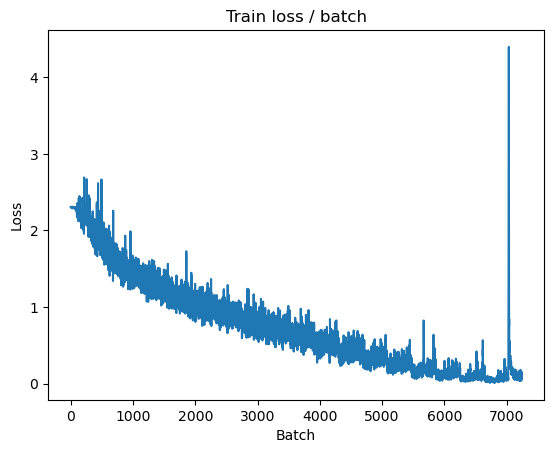


===============> Total time 32s	Avg loss 0.1193	Avg Prec@1 96.21 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 1.8205 (1.8205)	Prec@1  64.8 ( 64.8)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 1.5789	Avg Prec@1 69.66 %	Avg Prec@5 96.86 %



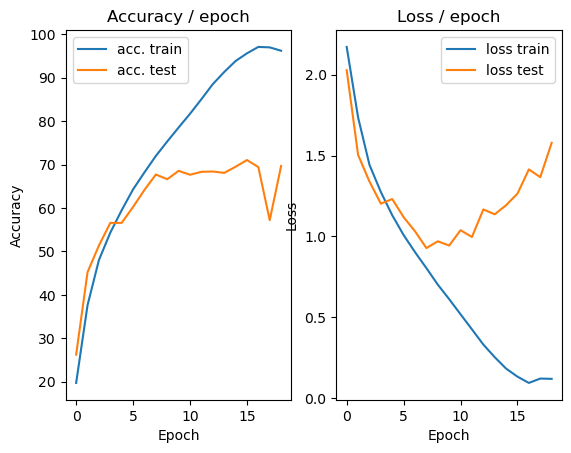

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.220s (0.220s)	Loss 0.0482 (0.0482)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


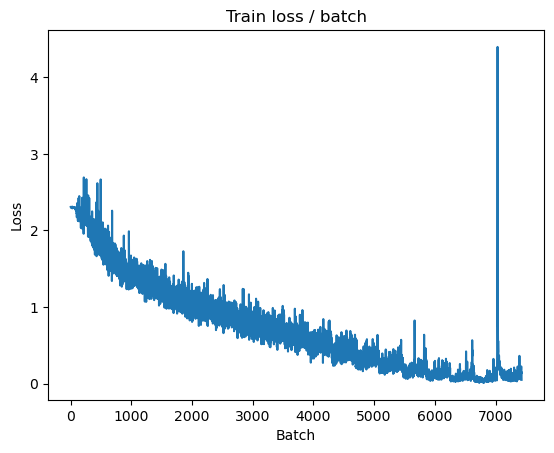

[TRAIN Batch 200/391]	Time 0.076s (0.080s)	Loss 0.0261 (0.0308)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


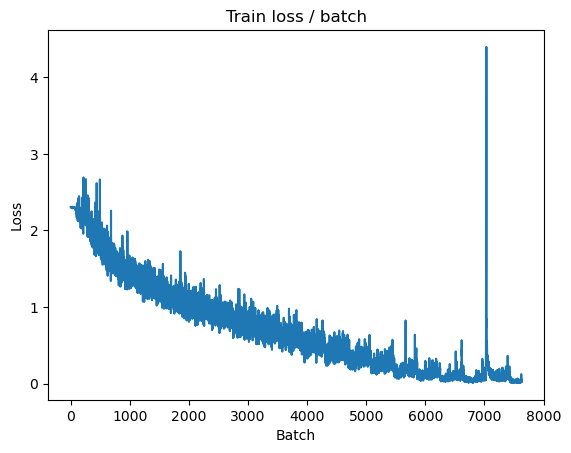


===============> Total time 31s	Avg loss 0.0413	Avg Prec@1 98.78 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 2.2143 (2.2143)	Prec@1  65.6 ( 65.6)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 2.1000	Avg Prec@1 66.39 %	Avg Prec@5 96.74 %



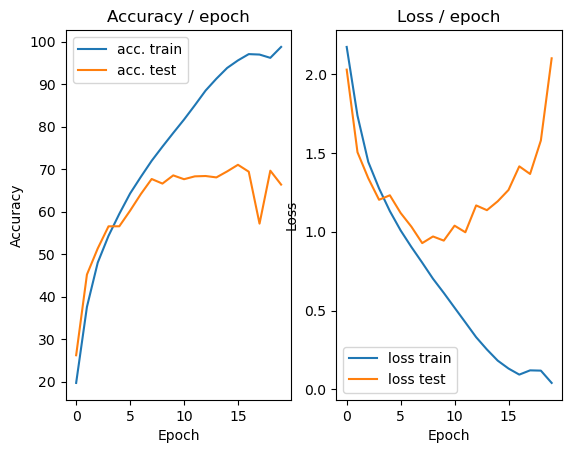

In [15]:
main(128, 0.1, epochs=20, cuda=False)